In [1]:
import os
import pandas as pd

In [2]:
print(os.getcwd())
print(os.path.isfile("../resources/BM510x3.txt.raw.gz"))

/Users/tweber/Gits/strandtools/notebooks
True


In [3]:
PATH_TO_DATA = '../resources/BM510x3.txt.raw.gz'
cwd = os.getcwd()
PATH_TO_STRANDTOOLS = os.path.join(cwd, "../")

In [4]:
# If not already present, download the test data:
if not os.path.isfile(PATH_TO_DATA):
    os.makedirs("../resources", exist_ok=True)

    # Download the test data
    print("Downloading test data...")
    !wget https://github.com/friendsofstrandseq/mosaicatcher-testdata/raw/main/data_ALL_CHROM/RPE-BM510/counts/BM510x3.txt.raw.gz resources/
else:
    print("Test data already present.")

Test data already present.


In [5]:
GC_path = os.path.join(PATH_TO_STRANDTOOLS,'resources', 'GRCh38.GC_matrix_200000.txt')

In [6]:
craw = pd.read_csv(PATH_TO_DATA, sep='\t', compression='gzip')

This is a classical Strand-seq file with the usual columns: sample, cell, chrom, start, end, c, w, class

In [7]:
craw.head()

chrom   start      end   sample            cell  c   w class
0  chr1       0   200000  BM510x3  BM510x3PE20401  4   6    WW
1  chr1  200000   400000  BM510x3  BM510x3PE20401  0   0    WW
2  chr1  400000   600000  BM510x3  BM510x3PE20401  2   0    WW
3  chr1  600000   800000  BM510x3  BM510x3PE20401  1   8    WW
4  chr1  800000  1000000  BM510x3  BM510x3PE20401  0  30    WW

The first thing to do is the multi-step normalization

In [8]:
from strandtools.normalization import library_normalization, gc_correction, vst, smoothing

In [9]:
craw['tot_count'] = craw['w'] + craw['c']
counts = library_normalization(craw, plot=True)

/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


For the GC correction, the parameter `n_subsample` defines how many data-points to consider for each GC decile.  
More data-points means more accurate correction, but also more computational time. For any practical purpose 250 data-points is more than enough.  
For the GC correction, we need the precomputed GC content for the genomic bins corresponding to the Strand-seq bins. This means that the GC matrix needs to correspond to reference genome, to which Strand-seq data was aligned.  
In the generated graphs, we can observe how the GC trend is corrected.

/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/normalization.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['GC'] = pd.to_numeric(c['GC'])
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtools/normalization.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['log_count_norm'] = np.log(c['tot_count']/c['tot_count'].median())
/Users/tweber/miniconda3/envs/strandtools-condaenv/lib/python3.11/site-packages/strandtool

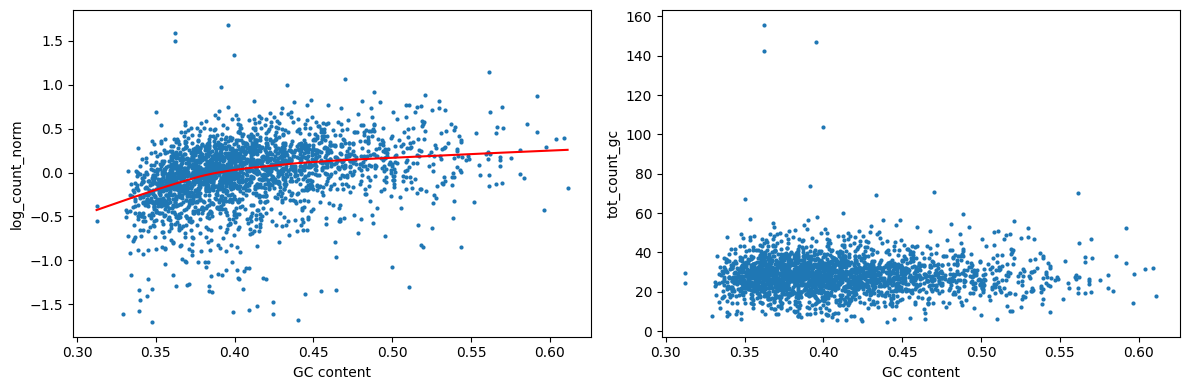

In [10]:
counts = gc_correction(counts, n_subsample=250, GC_path=GC_path, plot=True)

For the variance stabilization, except some really poor libraries, dispersion is usually below 0.1.  
So we don't need to search beyond that value, setting `phi_max` to 0.1  
After variance-stabilization, the data switched to a normal distribution.

  0%|          | 0/50 [00:00<?, ?it/s]

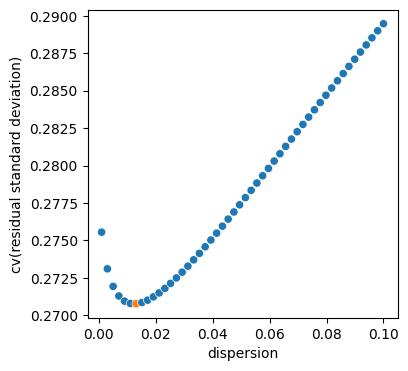

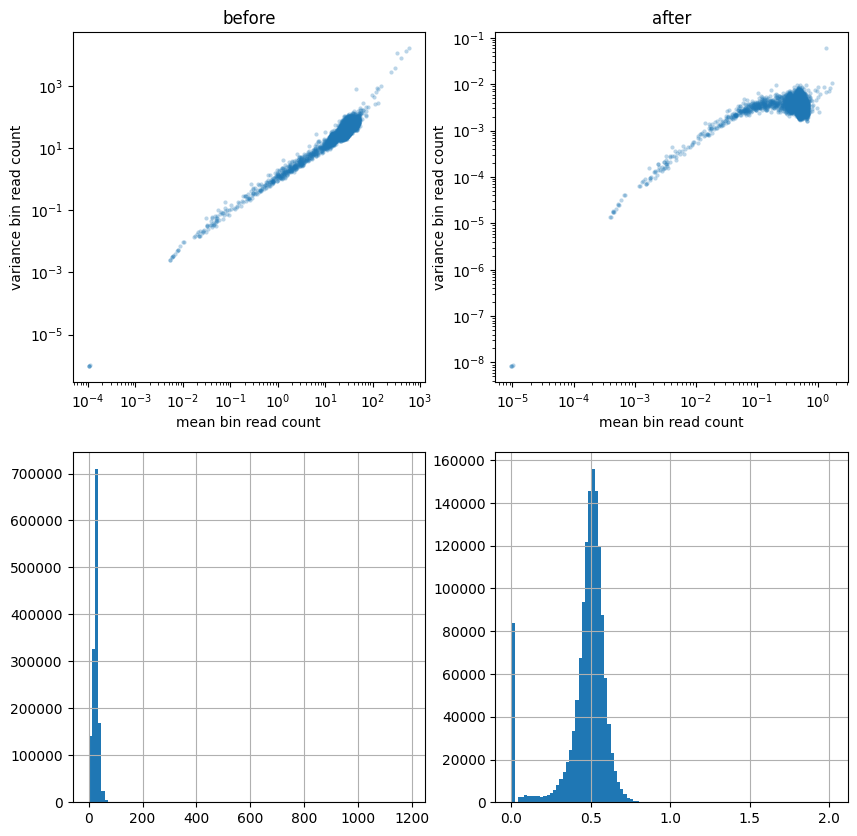

In [11]:
counts = vst(counts, phi_max=.1, plot=True)

Smoothing step is optional. Some marginal gains in prediction accuracy can be gained with smoothening the data, especially if cells have low counts.

In [12]:
counts = smoothing(counts, apply=True, clip_negative=True)

We can now visualize the results of the normalization

In [13]:
from strandtools.plot import plot_count_ratio, plot_count_ratio_plate

In [14]:
_ = plot_count_ratio(counts, bin_size=2e6)

In this graph we expect to observe clusters at the expected watson fraction `wf` ratios for the different copy numbers: for example 0, 0.5 and 1 for copy number 2. 0, 0.33, 0.66, 1 for copy number 3, etc.

At this stage, we want to inspect the tot count vs wf graph for each cell, to spot cells where clusters are not clearly defined, due to too much noise or incorrect BrdU incorporation, and remove them from the dataset.  
For this purpose, the `plot_count_ratio_plate` function can be utilized.

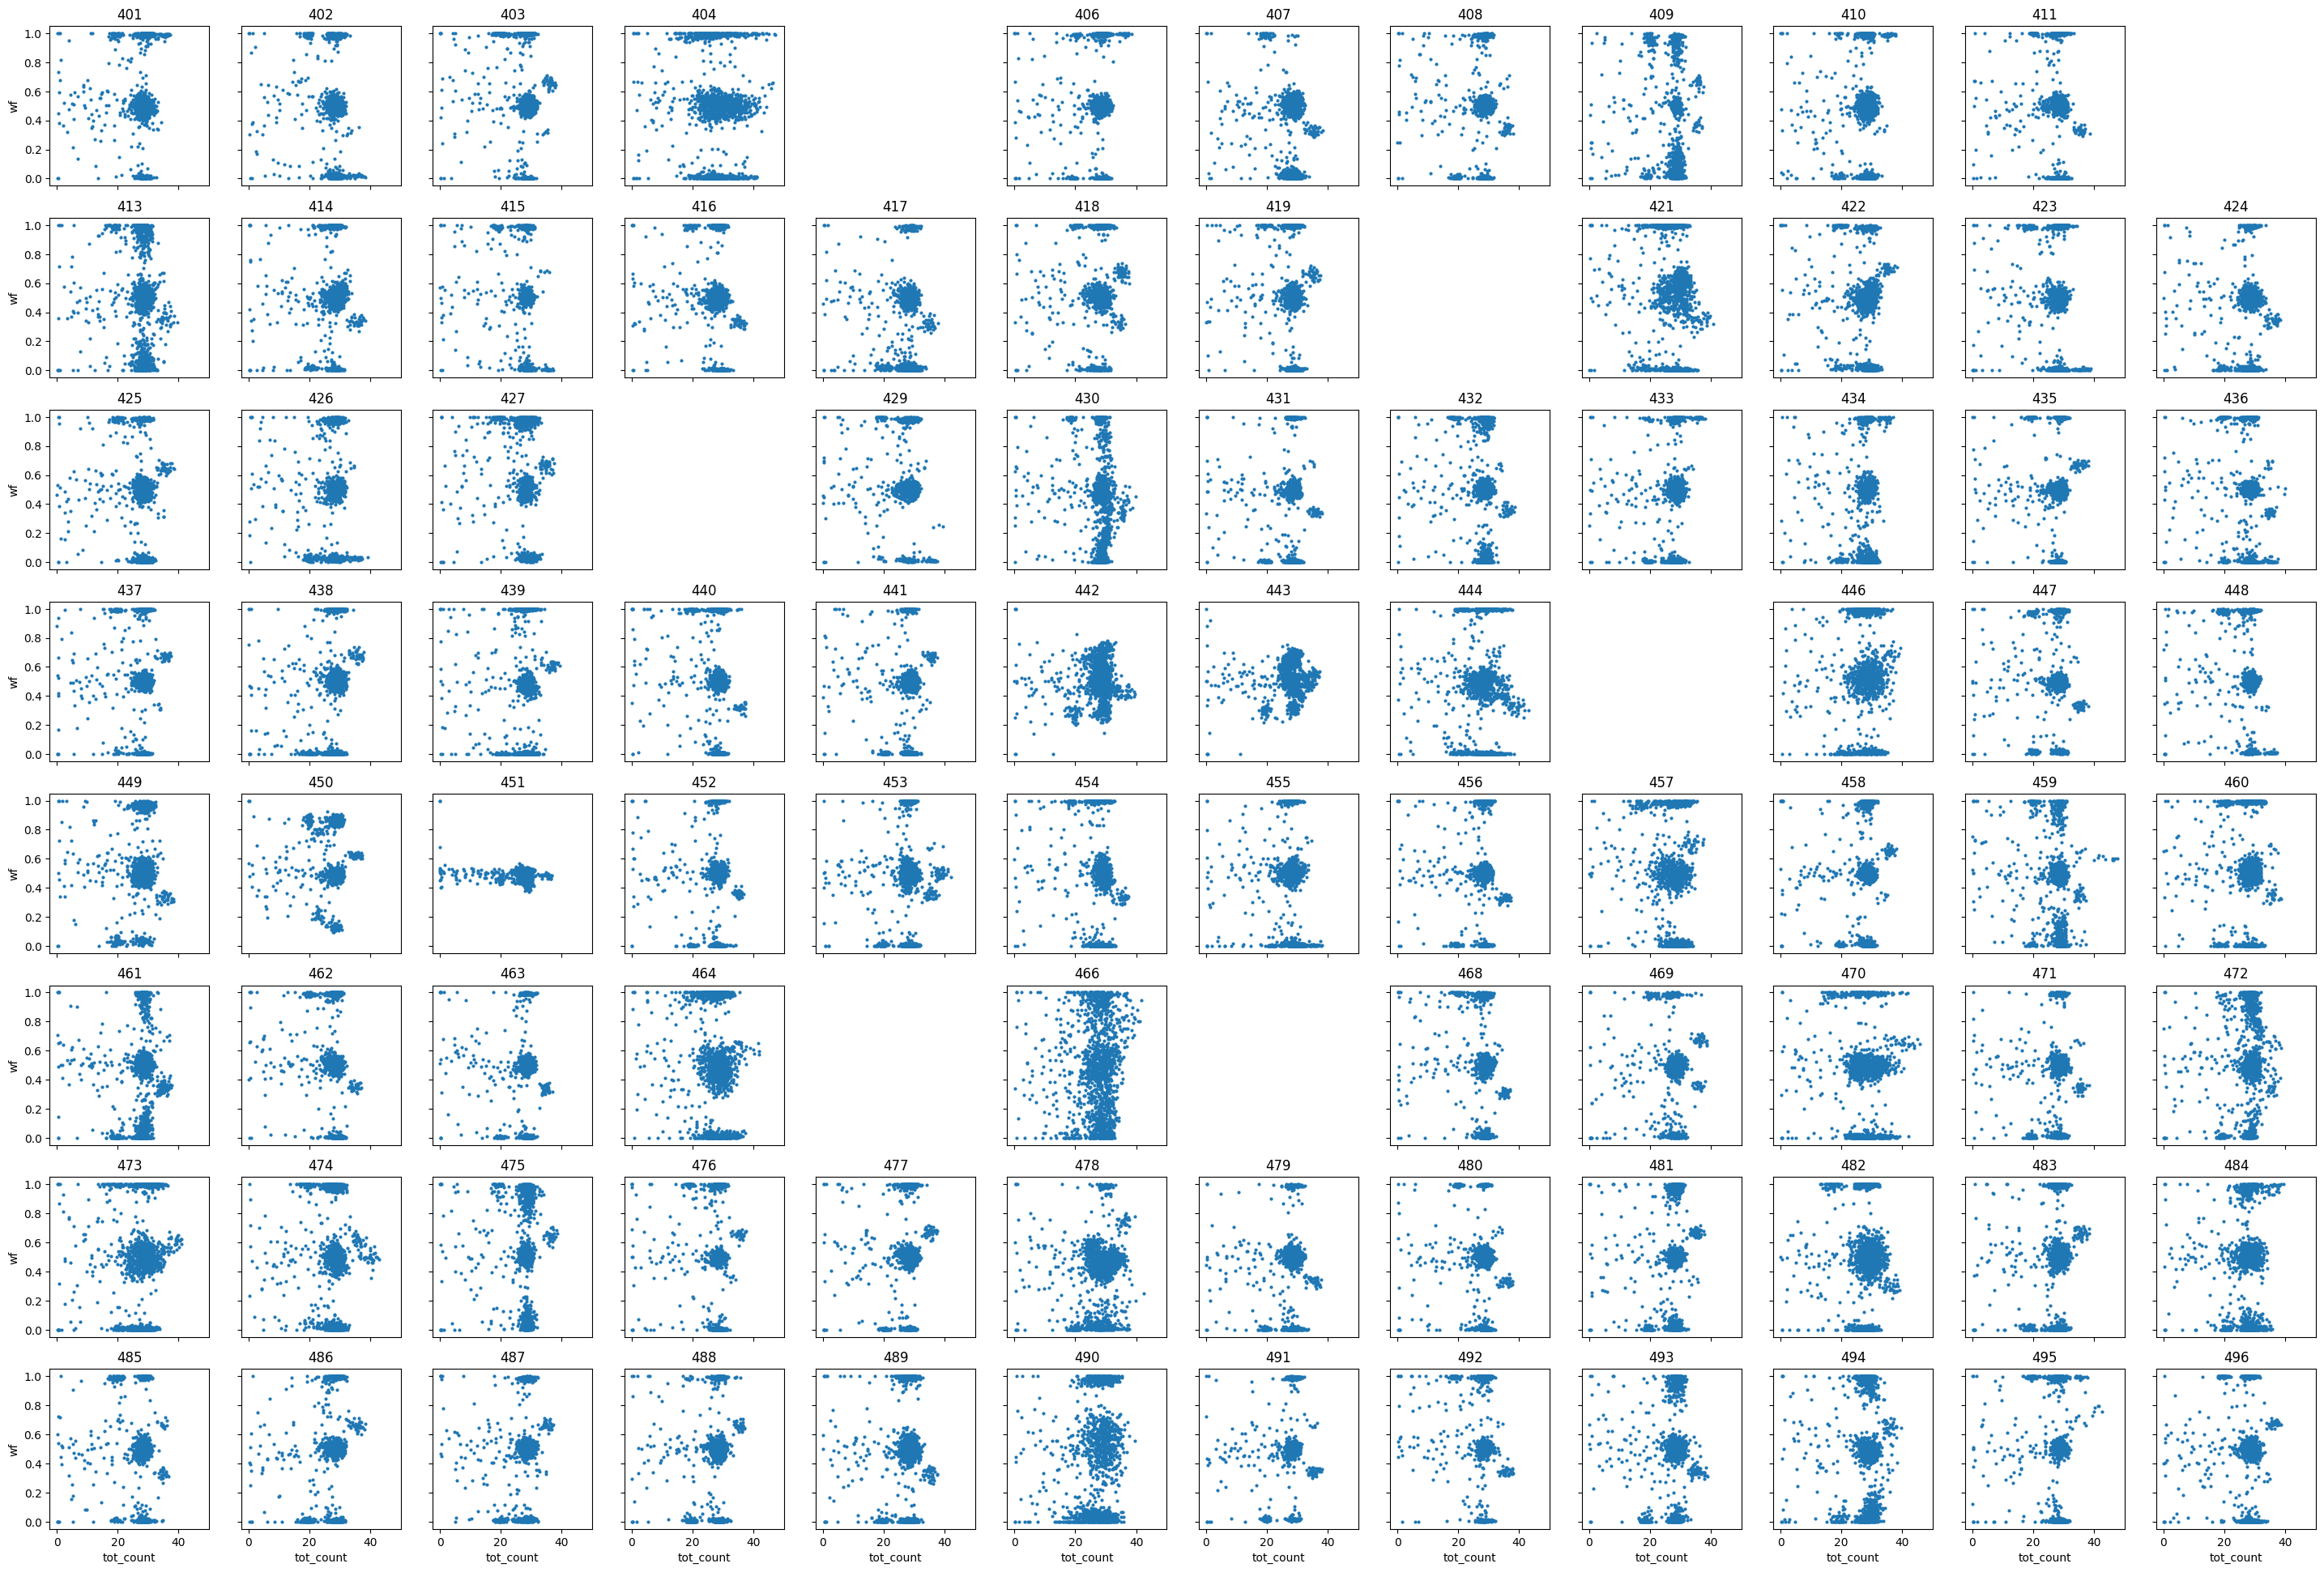

In [15]:
plot_count_ratio_plate(counts, bin_size=2e6)

Removing here bad quality cells

In [16]:
counts = counts[~counts['cell'].str.contains('404$|409$|413$|421$|430$|442$|443$|444$|446$|450$|451$|459$|461$|464$|466$|470$|472$|473$|475$|478$|484$|490$|494$')]

Congratulations! Your data now is ready for copy number calling!

In [17]:
SAVEPATH = os.path.join(PATH_TO_STRANDTOOLS, 'resources', 'BM510x3.txt.normalized.gz')
counts.to_csv(SAVEPATH, compression='gzip')